# Data Science Capstone Project - Sentiment Analysis on Tweets

#### Background 
Accompanying notebook for Capstone project of Udacity's Data Science Nanodegree. <br>
#### Context 
My chosen case study was Sentiment Analysis, in other words, processing natural language data to understand the writer's feelings or emotions. <br>
#### Data
I obtained my dataset from Kaggle.  The data is 1.6 million Tweets obtained from Twitter in 2009.  The Tweets are split evenly with 800k Tweets of Positive sentiment and 800k Tweets of Negative sentiment.  The data gives each Tweet an identifier, as well as giving the date (in the PDT timezone), the user who wrote the Tweet, and the text of the Tweet itself.  I thank Marios Michailidis for providing the dataset.
#### Results
The results of the analysis can be found at the following blog post on Medium: <br>
*** Remember to put blog post link in ***
#### References and Credits 
I learned a lot about model evaluation from the following two articles: <br>
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214 <br>
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ <br> 
I also utilised Stack Overflow and the library documentation, particilarly that for SciKitLearn.

## Import libraries and load data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import langdetect
from sqlalchemy import create_engine
from nltk import word_tokenize, TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("ticks")
sns.set_palette("colorblind")

In [3]:
# Specify column names as they are not in the CSV
cols = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

In [4]:
# Import data
tweets_raw = pd.read_csv('tweets.csv', encoding="utf-8", encoding_errors="ignore", header=None, names=cols)

In [16]:
# Check out the first few rows of the data
tweets_raw.head(10)

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


## Explore the data

In [96]:
tweets_raw.shape

(1600000, 6)

We're working with 1.6 million rows with 6 columns.

In [97]:
# Check a full text string
tweets_raw.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [98]:
# Check the balance of the data
tweets_raw.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

We have an exactly balanced dataset with 800k tweets each for positive and negative, where a 0 indicates a negative Tweet and 4 indicates a positive Tweet.

In [99]:
# Check balance of the flags column
tweets_raw.flag.value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

All rows have the "NO_QUERY" flag - we will just drop this column.

In [101]:
# Check for duplicates
tweets_raw[tweets_raw.duplicated()]

,sentiment,id,date,flag,user,text


There are no duplicates in our data.

In [102]:
# Check the top users
tweets_raw.user.value_counts()[:10]

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: user, dtype: int64

The top Tweeter in our date period posted 549 Tweets - an average of around 14 Tweets per day.

We can probably remove the user column as well as it shouldn't have any bearing in theory on whether a Tweet was negative or positive (although we can note that some users might be more likely to Tweet negatively and vice versa).

## Clean the data

### Drop the rows we don't need

In [103]:
tweets_raw = tweets_raw.drop(['id', 'date', 'flag', 'user'], axis=1)

In [104]:
tweets_raw.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [105]:
tweets_raw.text[:10]

0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
5                         @Kwesidei not the whole crew 
6                                           Need a hug 
7     @LOLTrish hey  long time no see! Yes.. Rains a...
8                  @Tatiana_K nope they didn't have it 
9                             @twittera que me muera ? 
10          spring break in plain city... it's snowing 
11                           I just re-pierced my ears 
12    @caregiving I couldn't bear to watch it.  And ...
13    @octolinz16 It it counts, idk why I did either...
14    @smarrison i would've been the first, but i di...
15    @iamjazzyfizzle I wish I got to watch it with ...
16    Hollis' death scene will hurt me severely to w...
17                                 about to file

It looks like a lot of tweets are replies to other people so we probably want to remove the reply handles.  The first tweet also has a link - we'll want to remove these too.  We should also replace emoji and hashtags with placeholders as well.

### Replace emojis with placeholders

In [2]:
# Source: https://en.wikipedia.org/wiki/List_of_emoticons
# We'll just take the most common emoji and generalise to happy/sad/laugh/shock
# e.g. we'll put "angry" emoji into "sad"

happy_emoji = [":‑))", ":)", ":-]", ":]", ":-3", ":3", ":->", ":>", "8-)", "8)", ":-}", ":}", ":o)", "B)",
":^)", "=]", "=)", ":-)", ";‑)", ";)", ";‑]", ";]", ";D", "B-)", 
":'‑)", ":')", ":‑P", ":P", "X‑P", "XP", "xp", ":‑p", ":p", 
"d:", "=p", ">:P", "O:‑)", "O:)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ":-*", ":*", ":×",
">:‑)", ">;)", ">:3", ";3"]

laugh_emoji = [":‑D", ":D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=D", "=3", "c:", "C:"]

sad_emoji = [":‑(", ":(", ":‑c", ":c", ":‑<", ":<", ":‑[", ":[", ":-||", ">:[", ":{", ":@", ":(", ":$",
";(", ":'‑(", ":'(", ":=(", "D‑':", "D:<", "D:", "D8", "D;", "D=", "DX", ":-/", ":/", ":‑.", ">:(", ">:-("
">:\\", ">:/", ":\\", "=/", "=\\", ":L", "=L", ":S", ":‑|", ":|", "<_<", ">_>", "<.<", ">.>"]

shock_emoji = [":‑O", ":O", ":‑o", ":o", ":-0", "8‑0", ">:O"]

emoji_dict = {"happyface": happy_emoji, 
              "laughface": laugh_emoji, 
              "sadface": sad_emoji, 
              "shockface": shock_emoji}


In the next step where we create a function to clean the text, we will need to tokenize the text.  For this use case, we will use NLTK's TweetTokenizer, an adaptation of the regular Tokenize function which is more suited to Twitter data.

In [3]:
# Set up tokenizer which we'll need in the next step
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, match_phone_numbers=False)

In [4]:
# Write a function that performing basic cleaning on the text data by replacing links, @ replies, hashtags, and emoji
def clean_text(text):
    '''
    Cleans the text data by replacing URLs, @-replies, hashtags, and emoji with text placeholders.
    
    INPUT:
    text - (str) text data to be cleaned
    
    OUTPUT:
    text - (str) cleaned text data with placeholders
    '''
    
    # Define regex expressions
    url_regex = 'https?\S+|www\.\S+'
    reply_regex = '@\S+'
    hashtag_regex = '#\S+'
    
    # Replace URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
        
    # Replace @ reply handles
    detected_replies = re.findall(reply_regex, text)
    for reply in detected_replies:
        text = text.replace(reply, "replyplaceholder")
        
    # Replace hashtags
    detected_hashtags = re.findall(hashtag_regex, text)
    for hashtag in detected_hashtags:
        text = text.replace(hashtag, "hashtagplaceholder")
        
    # Replace emoji by tokenizing then replacing common emoji with placeholders
    tokens = tokenizer.tokenize(text)
    
    for i in range(len(tokens)):
        for key, values in emoji_dict.items():
            if tokens[i] in values:
                tokens[i] = key
    
    # Convert back to text string        
    text = TreebankWordDetokenizer().detokenize(tokens)
    
    return text
    

In [111]:
# Apply the text cleaning to our text column
tweets_raw["clean_text"] = tweets_raw["text"].apply(lambda x: clean_text(x))

In [112]:
# Check the results
tweets_raw.head(10)

,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","replyplaceholder urlplaceholder - awww, that's..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,replyplaceholder i dived many times for the ba...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","replyplaceholder no, it's not behaving at all ..."
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,just woke up . having no school is the best fe...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb.com - very cool to hear old walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover? ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time!!! ...


Looks like the text cleaning has worked well.

In [113]:
# Drop the original text column now that we've got the cleaned text
tweets = tweets_raw.drop("text", axis=1)

In [114]:
# Rename the new column back to "text" for ease
tweets = tweets.rename(columns={"clean_text": "text"})

In [115]:
# Check the results
tweets

,sentiment,text
0,0,"replyplaceholder urlplaceholder - awww, that's..."
1,0,is upset that he can't update his facebook by ...
2,0,replyplaceholder i dived many times for the ba...
3,0,my whole body feels itchy and like its on fire
4,0,"replyplaceholder no, it's not behaving at all ..."
...,...,...
1599995,4,just woke up . having no school is the best fe...
1599996,4,thewdb.com - very cool to hear old walt interv...
1599997,4,are you ready for your mojo makeover? ask me f...
1599998,4,happy 38th birthday to my boo of alll time!!! ...


In [116]:
# Change sentiment column to read "positive" or "negative"
tweets.sentiment = tweets.sentiment.replace({0: "negative", 4: "positive"})

In [117]:
# Check the results
tweets

,sentiment,text
0,negative,"replyplaceholder urlplaceholder - awww, that's..."
1,negative,is upset that he can't update his facebook by ...
2,negative,replyplaceholder i dived many times for the ba...
3,negative,my whole body feels itchy and like its on fire
4,negative,"replyplaceholder no, it's not behaving at all ..."
...,...,...
1599995,positive,just woke up . having no school is the best fe...
1599996,positive,thewdb.com - very cool to hear old walt interv...
1599997,positive,are you ready for your mojo makeover? ask me f...
1599998,positive,happy 38th birthday to my boo of alll time!!! ...


In [118]:
# Double check we still have the same sentiment counts
tweets.sentiment.value_counts()

negative    800000
positive    800000
Name: sentiment, dtype: int64

In [119]:
tweets.text[0]

"replyplaceholder urlplaceholder - awww, that's a bummer . you shoulda got david carr of third day to do it . happyface"

In [120]:
tweets.text[1599996]

'thewdb.com - very cool to hear old walt interviews! ♫ urlplaceholder'

### Save clean data to an SQLite database for the future

In [122]:
# Save the dataframe
engine = create_engine('sqlite:///TweetsSentimentAnalysis.db')
tweets.to_sql('tweets_cleaned', engine, if_exists="replace", index=False)

In [17]:
# Load the dataframe - can start from here when working in the future
engine = create_engine('sqlite:///TweetsSentimentAnalysis.db')
tweets = pd.read_sql_table('tweets_cleaned', engine)

In [18]:
tweets

,sentiment,text
0,negative,"replyplaceholder urlplaceholder - awww, that's..."
1,negative,is upset that he can't update his facebook by ...
2,negative,replyplaceholder i dived many times for the ba...
3,negative,my whole body feels itchy and like its on fire
4,negative,"replyplaceholder no, it's not behaving at all ..."
...,...,...
1599995,positive,just woke up . having no school is the best fe...
1599996,positive,thewdb.com - very cool to hear old walt interv...
1599997,positive,are you ready for your mojo makeover? ask me f...
1599998,positive,happy 38th birthday to my boo of alll time!!! ...


## Data pre-processing

Now it's time to pre-process our data ready to train a machine learning model to predict the sentiment.  In this section we will:
* Create a function to tokenize the text
* Build a custom transformer to use in our Machine Learning Pipeline

### Create a tokenize function

### Check stopwords

In [6]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

There are quite a few negation words in the stopwords list such as "not", "won't", etc.  These could add important meaning to tweets so we'll do some manipulation to keep negations.

In [33]:
# List all of the negations we want to deal with
'''
not, don, don't, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't,
isn, isn't, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't,
won, won't, wouldn, wouldn't
'''

In [33]:
# Create a custom stopwords list
custom_stopwords = stopwords.words("english")

# Remove "no" and "not" from our stopwords
custom_stopwords.remove("not")
custom_stopwords.remove("no")

In [8]:
# Check our new stopwords list
custom_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

"no" and "not" have successfully been removed from our stopwords list.  In the next step we will deal with a few edge cases, then replace the expression "n't" with the full word "not" so that negations are not removed as part of stopword removal.

In [31]:
# Set up tokenizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, match_phone_numbers=False)

In [32]:
# Tokenize function
def tokenize(text):
    '''
    Takes text strings as input, alters negations to their full form, normalizes, tokenizes, lemmatizes the text, and removes
    stopwords using our custom stopwords list.
    
    INPUT:
    text - (str) text string to be tokenized
    
    OUTPUT:
    tokens - (list) list of cleaned text tokens
    '''
    
    # Replace some negation words with their full form
    text = text.replace("can't", "can not")
    text = text.replace("won't", "will not")
    text = text.replace("shan't", "shall not")
    
    # Change "n't" to add the full word "not" as a separate word, so it doesn't get removed with stopword removal
    text = text.replace("n't", " not")
    
    # Normalise the text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Tokenise the text using TweetTokenizer
    tokens = tokenizer.tokenize(text)
    
    # Lemmatise and remove stopwords
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in custom_stopwords]
    
    return tokens


### Test out our tokenize function

In [9]:
# Split out into text and sentiment
X = tweets["text"]
Y = tweets["sentiment"]

In [131]:
tokens_test = tokenize(X[0])
tokens_test

['replyplaceholder',
 'urlplaceholder',
 'awww',
 'bummer',
 'shoulda',
 'got',
 'david',
 'carr',
 'third',
 'day',
 'happyface']

In [132]:
tokens_test = tokenize(X[1])
tokens_test

['upset',
 'not',
 'update',
 'facebook',
 'texting',
 'might',
 'cry',
 'result',
 'school',
 'today',
 'also',
 'blah']

We can see in the example above that the negation "not" has been kept as we wanted.

In [133]:
tokens_test = tokenize(X[2])
tokens_test

['replyplaceholder',
 'dived',
 'many',
 'time',
 'ball',
 'managed',
 'save',
 '50',
 'rest',
 'go',
 'bound']

In [134]:
tokens_test = tokenize(X[1000])
tokens_test

['replyplaceholder',
 'replyplaceholder',
 'um',
 'would',
 'hell',
 'no',
 'fugly',
 'poker',
 'dog',
 'pant',
 'cruise',
 'hi',
 'jonathan',
 'sorry',
 'missed']

In [135]:
tokens_test = tokenize(X[2000])
tokens_test

['morning',
 'twitterati',
 'large',
 'coffee',
 'bath',
 'top',
 'today',
 'list',
 'first',
 'appt',
 '10am',
 'load',
 'desk',
 'work']

### Wordclouds of most common words in negative and positive tweets

In [120]:
# Make a list of all the positive text from the cleaned column
positive_tweets = tweets[tweets['sentiment'] == 'positive']['text'].to_list()

In [122]:
positive_words = ' '.join(positive_tweets)

In [123]:
# Use part of the tokenize function to clean up the text a bit
positive_words = positive_words.replace("can't", "can not")
positive_words = positive_words.replace("won't", "will not")
positive_words = positive_words.replace("shan't", "shall not")

# Change "n't" to add the full word "not" as a separate word, so it doesn't get removed with stopwords
positive_words = positive_words.replace("n't", " not")

# Normalise the text
positive_words = re.sub(r"[^a-zA-Z0-9]", " ", positive_words)

# Remove the placeholders we created earlier apart from the emoji placeholders
positive_words = positive_words.replace("replyplaceholder", "")
positive_words = positive_words.replace("urlplaceholder", "")
positive_words = positive_words.replace("hashtagplaceholder", "")

In [124]:
# Generate the wordcloud of most common words in positive Tweets
positive_wordcloud = WordCloud(
    width=1200, 
    height=800, 
    stopwords=custom_stopwords,
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set2'
).generate(positive_words)

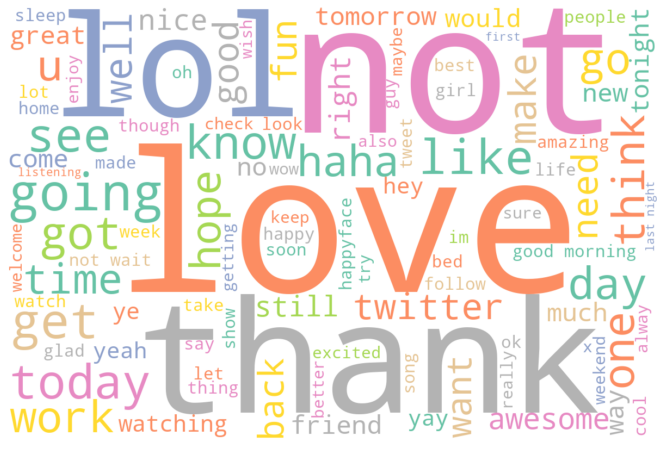

In [125]:
# Plot the wordcloud
plt.figure(figsize=[12,8])
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [126]:
# Make a list of all the netagive text from the cleaned column
negative_tweets = tweets[tweets['sentiment'] == 'negative']['text'].to_list()

In [127]:
negative_words = ' '.join(negative_tweets)

In [128]:
# Use part of the tokenize function to clean up the text a bit
negative_words = negative_words.replace("can't", "can not")
negative_words = negative_words.replace("won't", "will not")
negative_words = negative_words.replace("shan't", "shall not")

# Change "n't" to add the full word "not" as a separate word, so it doesn't get removed with stopwords
negative_words = negative_words.replace("n't", " not")

# Normalise the text
negative_words = re.sub(r"[^a-zA-Z0-9]", " ", negative_words)

# Remove the placeholders we created earlier apart from the emoji placeholders
negative_words = negative_words.replace("replyplaceholder", "")
negative_words = negative_words.replace("urlplaceholder", "")
negative_words = negative_words.replace("hashtagplaceholder", "")

In [129]:
# Generate the wordcloud of most common words in negative Tweets
negative_wordcloud = WordCloud(
    width=1200, 
    height=800, 
    stopwords=custom_stopwords,
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set2'
).generate(negative_words)

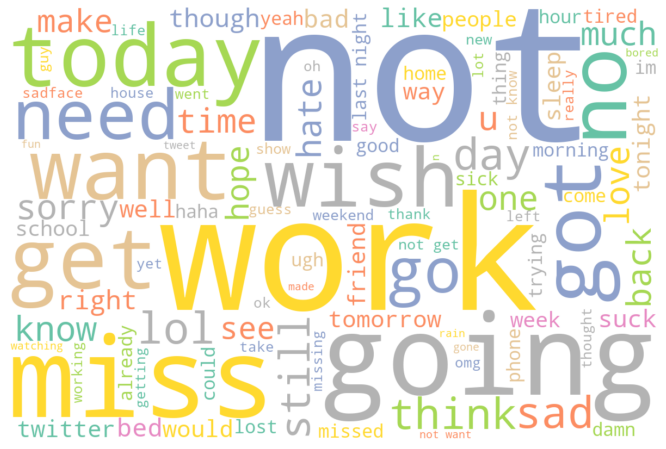

In [130]:
plt.figure(figsize=[12,8])
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Feature engineering - Create a custom transformer

In this section we will perform some feature engineering to create a custom transformer to use in our machine learning pipeline.

Features to explore:
* Text length
* Word count
* Number of hashtags
* Number of URLs
* Number of emoji
* Number of users @-replied to
* Proportion of words that are hashtags
* Proportion of words that are emoji

In [3]:
# Create a function that returns the length of the text
def count_text_length(text):
    return len(text)

In [4]:
# Choose a text string to test
tweets.text.iloc[795000]

"was having dinner with parents downstairs in dining room, they started watching' baba ramdev yoga' thingy, so i'm back to my room."

In [5]:
count_text_length(tweets.text.iloc[795000])

130

The text length won't necessarily be accurate because we have already changed hashtags, @-replies, and emoji into placeholders.  Hence we should probably leave this one out.

In [7]:
# Create a function that counts the words in the Tweet
def count_words(text):
    words_in_tweet = text.split()
    num_words = len(words_in_tweet)
    return num_words

In [8]:
count_words(tweets.text.iloc[795000])

22

In [9]:
# Create a function that counts the number of hashtags in the Tweet
def count_hashtags(text):
    num_hashtags = text.count("hashtagplaceholder")
    return num_hashtags

In [10]:
# Choose a tweet to test
tweets.text.iloc[1599999]

'happy hashtagplaceholder replyplaceholder replyplaceholder replyplaceholder'

In [11]:
count_hashtags(tweets.text.iloc[1599999])

1

In [12]:
count_hashtags("happy birthday hashtagplaceholder hashtagplaceholder hashtagplaceholder")

3

In [13]:
# Create a function that counts the number of @-replies in the Tweet
def count_replies(text):
    num_replies = text.count("replyplaceholder")
    return num_replies

In [14]:
tweets.text[0]

"replyplaceholder urlplaceholder - awww, that's a bummer . you shoulda got david carr of third day to do it . happyface"

In [15]:
count_replies(tweets.text[0])

1

In [16]:
# Create a function that counts the number of URLs in the Tweet
def count_urls(text):
    num_urls = text.count("urlplaceholder")
    return num_urls

In [17]:
count_urls(tweets.text[0])

1

In [18]:
# Create a function that counts the number of emoji in the Tweet
def count_emoji(text):
    num_emoji = 0
    for emoji in emoji_dict.keys():
        num_emoji += text.count(emoji)
    return num_emoji

In [21]:
count_emoji(tweets.text[0])

1

In [22]:
count_emoji("happyface sadface laughface shockface")

4

In [23]:
# Create a function that finds the proportion of the Tweet that is made up of hashtags
def proportion_of_hashtags(text):
    word_count = count_words(text)
    hashtag_count = count_hashtags(text)
    return hashtag_count/word_count

In [24]:
# Choose a tweet to test
tweets.text[1599999]

'happy hashtagplaceholder replyplaceholder replyplaceholder replyplaceholder'

In [25]:
proportion_of_hashtags(tweets.text[1599999])

0.2

In [26]:
# Create a function that finds the proportion of the Tweet that is made up of emoji
def proportion_of_emoji(text):
    word_count = count_words(text)
    emoji_count = count_emoji(text)
    return emoji_count/word_count

In [27]:
proportion_of_emoji(tweets.text[0])

0.047619047619047616

### Summarise all of the above functions

In [11]:
def count_words(text):
    '''
    Find the number of words in a given text string
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    num_words - (int) number of words in the input string
    '''
    
    words_in_tweet = text.split()
    num_words = len(words_in_tweet)
    return num_words

def count_hashtags(text):
    '''
    Find the number of hashtags in a given text
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    num_hashtags - (int) number of hashtags in the input string
    '''
    
    num_hashtags = text.count("hashtagplaceholder")
    return num_hashtags

def count_replies(text):
    '''
    Find the number of @-replies in a given text string
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    num_replies - (int) number of @-replies in the input string
    '''
    num_replies = text.count("replyplaceholder")
    return num_replies

def count_urls(text):
    '''
    Find the number of URLs in a given text string
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    num_urls - (int) number of URLs in the input string
    '''
    
    num_urls = text.count("urlplaceholder")
    return num_urls

def count_emoji(text):
    '''
    Find the number of emoji in a given text string
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    num_emoji - (int) number of emoji in the input string
    '''
    
    num_emoji = 0
    for emoji in emoji_dict.keys():
        num_emoji += text.count(emoji)
    return num_emoji

def proportion_of_hashtags(text):
    '''
    Find the proportion of a text string that is made up of hashtags.  Makes use of the count_words() and 
    count_hashtags() functions above
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    hashtag_count/word_count - (float) proportion of hashtags present in the input string
    '''
    
    word_count = count_words(text)
    hashtag_count = count_hashtags(text)
    return hashtag_count/word_count

def proportion_of_emoji(text):
    '''
    Find the proportion of a text string that is made up of emoji.  Makes use of the count_words() and 
    count_emoji() functions above
    
    INPUT:
    text - (str) text string
    
    OUTPUT:
    emoji_count/word_count - (float) proportion of emoji present in the input string
    '''
    
    word_count = count_words(text)
    emoji_count = count_emoji(text)
    return emoji_count/word_count

In [12]:
class TextCountsTransformer(BaseEstimator, TransformerMixin):
    '''
    Custom transformer which extracts features relating to counts from input text data and returns the features as new columns
    '''
    
    def text_feature_extract(self, text):
        word_count = np.asarray(count_words(text))
        hashtag_count = np.asarray(count_hashtags(text))
        reply_count = np.asarray(count_replies(text))
        url_count = np.asarray(count_urls(text))
        emoji_count = np.asarray(count_emoji(text))
        hashtag_prop = np.asarray(proportion_of_hashtags(text))
        emoji_prop = np.asarray(proportion_of_emoji(text))
        
        features = pd.Series({"word_count": word_count, 
                              "hashtag_count": hashtag_count, 
                              "reply_count": reply_count, 
                              "url_count": url_count, 
                              "emoji_count": emoji_count, 
                              "hashtag_proportion": hashtag_prop, 
                              "emoji_proportion": emoji_prop})

        return features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.text_feature_extract)
        return X_tagged.astype(float)
    

### Create subset of our Tweets data to test more quickly

In [37]:
# taking 10k rows from the middle of the dataset so that we still have an even split of positive and negative tweets
tweets_subset = tweets[795000:805000]

In [38]:
# Check we have the correct split of positive and negative Tweets
tweets_subset.sentiment.value_counts()

negative    5000
positive    5000
Name: sentiment, dtype: int64

In [39]:
tweets_subset

,sentiment,text
795000,negative,was having dinner with parents downstairs in d...
795001,negative,blah 5am still up daang i got deep problems
795002,negative,replyplaceholder i would suggest avoiding 360 ...
795003,negative,replyplaceholder i didn't convince myself i wa...
795004,negative,replyplaceholder replyplaceholder check on sun...
...,...,...
804995,positive,replyplaceholder thanks for sending us the pac...
804996,positive,replyplaceholder hahahha .. u obviously don't ...
804997,positive,"replyplaceholder it's an internet term, but it..."
804998,positive,new day...new track!!!


In [178]:
X = tweets_subset["text"]
Y = tweets_subset["sentiment"]

### Test out our transformer on the subset of the Tweets data

In [306]:
counts_transformer = TextCountsTransformer()

In [307]:
X_transformed = counts_transformer.fit_transform(X)

In [308]:
X_transformed

,word_count,hashtag_count,reply_count,url_count,emoji_count,hashtag_proportion,emoji_proportion
795000,22.0,0.0,0.0,0.0,0.0,0.0,0.000000
795001,9.0,0.0,0.0,0.0,0.0,0.0,0.000000
795002,18.0,0.0,2.0,0.0,0.0,0.0,0.000000
795003,25.0,0.0,1.0,0.0,0.0,0.0,0.000000
795004,23.0,0.0,2.0,0.0,1.0,0.0,0.043478
...,...,...,...,...,...,...,...
804995,12.0,0.0,1.0,0.0,0.0,0.0,0.000000
804996,20.0,0.0,1.0,0.0,0.0,0.0,0.000000
804997,15.0,0.0,1.0,0.0,0.0,0.0,0.000000
804998,3.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Modelling

Now we have cleaned and pre-processed our text data as well as created a custom transformer to use in our Machine Learning pipeline.  It's time to build the pipeline and train our model.

We will perform the initial model training on the subset of the Tweets data we created ealier, to speed up testing.  Once we have selected a model we will train on the whole dataset, performing Grid Search to choose the best hyperparameters.

We will test out different classifications models and make our selection based on a combination of metric scores and interpretability.

### Split the subset into training and testing sets

In [179]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [180]:
# Check size of training data
X_train.shape

(7500,)

In [181]:
# Check size of testing data
X_test.shape

(2500,)

### Start by trying a Decision Tree Classifier

In [113]:
# Create Pipeline, utilising Feature Union so that we can apply all three transformers on the same initial data
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('counts', TextCountsTransformer())
    ])),
    ('clf', DecisionTreeClassifier())
])

In [114]:
# Fit the pipeline
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x0000025430562D30>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('counts',
                                                 TextCountsTransformer())])),
                ('clf', DecisionTreeClassifier())])

In [115]:
# Make predictions using the trained model
Y_pred = pipeline.predict(X_test)

In [116]:
# Use classification report to find the precision, recall, f1-score, and accuracy
print(classification_report(Y_test, Y_pred, zero_division=0))

              precision    recall  f1-score   support

    negative       0.71      0.68      0.69      1272
    positive       0.68      0.71      0.70      1228

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



The Decision Tree classifier gives an overall accuracy of 0.70 which is a good start.

In [117]:
# Now let's try removing our custom transformer
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))
    ])),
    ('clf', DecisionTreeClassifier())
])

In [118]:
# Fit the pipeline
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x0000025430562D30>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())]))])),
                ('clf', DecisionTreeClassifier())])

In [119]:
# Make predictions using the trained model
Y_pred = pipeline.predict(X_test)

In [120]:
# Use classification report to find the precision, recall, f1-score, and accuracy
print(classification_report(Y_test, Y_pred, zero_division=0))

              precision    recall  f1-score   support

    negative       0.70      0.73      0.72      1272
    positive       0.71      0.68      0.69      1228

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



The overall accuracy with the custom transformer removed is 0.71, a little higher.  Is this an early indication that our custom transformer actually impacts our model in a negative way?

### Spot check some Tweets - some made up and some taken from Twitter

In [337]:
# negative
pipeline.predict(["OMG I really hate this stupid website :("])

array(['negative'], dtype=object)

In [338]:
# negative
pipeline.predict(["feel really sick today"])

array(['negative'], dtype=object)

In [339]:
# positive
pipeline.predict(["is watching Dancing on Ice LMAO"])

array(['positive'], dtype=object)

In [340]:
# negative
pipeline.predict(["can't believe the banking app is down again, endless"])

array(['negative'], dtype=object)

In [341]:
# negative
pipeline.predict(["Ew dude a youtuber?! Man they'll let anyone in these days"])

array(['positive'], dtype=object)

In [342]:
# negative
pipeline.predict(["i finally got to play pure yordles - got everything 6 starred and got my first veigar then i promptly died next turn :("])

array(['negative'], dtype=object)

In [343]:
# positive
pipeline.predict(["7 years ago I finished 2 degrees while also working on my nail art blog. Tuition is $$$, and it can be hard to pursue your creative passions and education at the same time. So I started a scholarship that supports students who are doing both every year, forever!!"])

array(['positive'], dtype=object)

In [344]:
# negative
pipeline.predict(["Students who protested against the far right Israeli Ambassador have been demonised by mainstream media outlets, and by Tory and Labour politicians. This is the truth."])

array(['positive'], dtype=object)

## Let's try some different classifiers - testing with our custom transformer and without

### Create a function to make testing other models easier

In [10]:
def fit_train_test_model(X, Y, classifier, incl_custom_transformer):
    '''
    A function to more easily test different Machine Learning models.  The function builds a Pipeline, splits
    the data into training and test sets, trains the model, tests the model against some example Tweets,
    and prints the classification report for the model.
    
    The user has the option when calling the function whether or not to include the custom transformer,
    TextCountsTransformer(), in the Pipeline.
    
    INPUTS:
    X - (series) text column from our data
    Y - (series) target output column from our data
    classifier - model to be used
    incl_custom_transformer - (boolean) indicates whether or not to use the custom transformer
    
    OUTPUTS:
    pipeline - (Pipeline object) our trained model
    Classification report for the model, and indicator of how many example Tweets the model correctly classified
    '''
    
    # Specify the pipeline - include custom transformer if specified in input
    if incl_custom_transformer:
        pipeline = Pipeline([
            ('features', FeatureUnion([
                ('text_pipeline', Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer())
                ])),
                ('counts', TextCountsTransformer())
            ])),
            ('clf', classifier)
        ])
    else:
        pipeline = Pipeline([
            ('features', FeatureUnion([
                ('text_pipeline', Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer())
                ]))
            ])),
            ('clf', classifier)
        ])
    
    # Train the pipeline and make predictions
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    
    # Test model on some example Tweets
    test_tweets = [
        ["OMG I really hate this stupid website :("],
        ["feel really sick today"],
        ["is watching Dancing on Ice LMAO"],
        ["can't believe the banking app is down again, endless"],
        ["Ew dude a youtuber?! Man they'll let anyone in these days"],
        ["i finally got to play pure yordles - got everything 6 starred and got my first veigar then i promptly died next turn :("],
        ["7 years ago I finished 2 degrees while also working on my nail art blog. Tuition is $$$, and it can be hard to pursue your creative passions and education at the same time. So I started a scholarship that supports students who are doing both every year, forever!!"],
        ["Students who protested against the far right Israeli Ambassador have been demonised by mainstream media outlets, and by Tory and Labour politicians. This is the truth."]
    ]
    
    test_tweets_true_sentiments = ["negative", "negative", "positive", "negative", "negative", "negative", "positive", "negative"]
    
    score = 0
    for i in range(0, len(test_tweets)):
        result = pipeline.predict(test_tweets[i])[0]
        if result == test_tweets_true_sentiments[i]:
            score += 1
    
    # Print Classification Report
    print("{} Report:".format(classifier))
    print(classification_report(Y_test, Y_pred, zero_division=0))
    print("TextCountsTransformer() custom transformer used: {}".format(incl_custom_transformer))
    
    # Print results from our example tweets
    print("The {} model correctly classified {}/{} of the test Tweets.".format(classifier, score, len(test_tweets)))
    
    return pipeline

### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [183]:
pipeline = fit_train_test_model(X, Y, LogisticRegression(), True)

C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Report:
              precision    recall  f1-score   support

    negative       0.77      0.74      0.75      1272
    positive       0.74      0.77      0.75      1228

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500

TextCountsTransformer() custom transformer used: True
The LogisticRegression() model correctly classified 5/8 of the test Tweets.


In [184]:
pipeline = fit_train_test_model(X, Y, LogisticRegression(), False)

LogisticRegression() Report:
              precision    recall  f1-score   support

    negative       0.77      0.73      0.75      1272
    positive       0.74      0.78      0.76      1228

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500

TextCountsTransformer() custom transformer used: False
The LogisticRegression() model correctly classified 4/8 of the test Tweets.


Logistic Regression has better scores than Decision Tree even without hyperparameter tuning - it is also fairly easy to interpret.

### Gradient Boosting

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [185]:
pipeline = fit_train_test_model(X, Y, GradientBoostingClassifier(), True)

GradientBoostingClassifier() Report:
              precision    recall  f1-score   support

    negative       0.71      0.73      0.72      1272
    positive       0.71      0.70      0.70      1228

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500

TextCountsTransformer() custom transformer used: True
The GradientBoostingClassifier() model correctly classified 7/8 of the test Tweets.


In [186]:
pipeline = fit_train_test_model(X, Y, GradientBoostingClassifier(), False)

GradientBoostingClassifier() Report:
              precision    recall  f1-score   support

    negative       0.71      0.73      0.72      1272
    positive       0.71      0.69      0.70      1228

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500

TextCountsTransformer() custom transformer used: False
The GradientBoostingClassifier() model correctly classified 7/8 of the test Tweets.


Gradient Boosting doesn't perform that much better than Decision Tree.

### Random Forest Classifier

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [187]:
pipeline = fit_train_test_model(X, Y, RandomForestClassifier(), True)

RandomForestClassifier() Report:
              precision    recall  f1-score   support

    negative       0.73      0.75      0.74      1272
    positive       0.74      0.72      0.73      1228

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500

TextCountsTransformer() custom transformer used: True
The RandomForestClassifier() model correctly classified 6/8 of the test Tweets.


In [188]:
pipeline = fit_train_test_model(X, Y, RandomForestClassifier(), False)

RandomForestClassifier() Report:
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75      1272
    positive       0.75      0.73      0.74      1228

    accuracy                           0.74      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.74      0.74      0.74      2500

TextCountsTransformer() custom transformer used: False
The RandomForestClassifier() model correctly classified 6/8 of the test Tweets.


Random Forest has better scores than Decision Tree but is a bit harder to interpret.

### SVC

In [87]:
from sklearn.svm import SVC

In [189]:
pipeline = fit_train_test_model(X, Y, SVC(), True)

SVC() Report:
              precision    recall  f1-score   support

    negative       0.61      0.64      0.63      1272
    positive       0.61      0.57      0.59      1228

    accuracy                           0.61      2500
   macro avg       0.61      0.61      0.61      2500
weighted avg       0.61      0.61      0.61      2500

TextCountsTransformer() custom transformer used: True
The SVC() model correctly classified 6/8 of the test Tweets.


In [190]:
pipeline = fit_train_test_model(X, Y, SVC(), False)

SVC() Report:
              precision    recall  f1-score   support

    negative       0.78      0.75      0.76      1272
    positive       0.75      0.78      0.76      1228

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500

TextCountsTransformer() custom transformer used: False
The SVC() model correctly classified 4/8 of the test Tweets.


Strangely, SVC performs far worse when we include the custom transformer, but performs quite well without it.

### Linear SVC

In [92]:
from sklearn.svm import LinearSVC

In [191]:
pipeline = fit_train_test_model(X, Y, LinearSVC(), True)

C:\Users\rache\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC() Report:
              precision    recall  f1-score   support

    negative       0.76      0.75      0.75      1272
    positive       0.74      0.75      0.75      1228

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500

TextCountsTransformer() custom transformer used: True
The LinearSVC() model correctly classified 4/8 of the test Tweets.


In [192]:
pipeline = fit_train_test_model(X, Y, LinearSVC(), False)

LinearSVC() Report:
              precision    recall  f1-score   support

    negative       0.76      0.73      0.75      1272
    positive       0.73      0.75      0.74      1228

    accuracy                           0.74      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.74      0.74      0.74      2500

TextCountsTransformer() custom transformer used: False
The LinearSVC() model correctly classified 3/8 of the test Tweets.


### K Neighbors

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [193]:
pipeline = fit_train_test_model(X, Y, KNeighborsClassifier(), True)

KNeighborsClassifier() Report:
              precision    recall  f1-score   support

    negative       0.62      0.69      0.66      1272
    positive       0.64      0.57      0.60      1228

    accuracy                           0.63      2500
   macro avg       0.63      0.63      0.63      2500
weighted avg       0.63      0.63      0.63      2500

TextCountsTransformer() custom transformer used: True
The KNeighborsClassifier() model correctly classified 4/8 of the test Tweets.


In [194]:
pipeline = fit_train_test_model(X, Y, KNeighborsClassifier(), False)

KNeighborsClassifier() Report:
              precision    recall  f1-score   support

    negative       0.66      0.79      0.72      1272
    positive       0.73      0.58      0.64      1228

    accuracy                           0.69      2500
   macro avg       0.69      0.68      0.68      2500
weighted avg       0.69      0.69      0.68      2500

TextCountsTransformer() custom transformer used: False
The KNeighborsClassifier() model correctly classified 5/8 of the test Tweets.


### Extra Trees

In [98]:
from sklearn.ensemble import ExtraTreesClassifier

In [195]:
pipeline = fit_train_test_model(X, Y, ExtraTreesClassifier(), True)

ExtraTreesClassifier() Report:
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76      1272
    positive       0.75      0.76      0.75      1228

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500

TextCountsTransformer() custom transformer used: True
The ExtraTreesClassifier() model correctly classified 6/8 of the test Tweets.


In [196]:
pipeline = fit_train_test_model(X, Y, ExtraTreesClassifier(), False)

ExtraTreesClassifier() Report:
              precision    recall  f1-score   support

    negative       0.75      0.78      0.76      1272
    positive       0.76      0.73      0.74      1228

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500

TextCountsTransformer() custom transformer used: False
The ExtraTreesClassifier() model correctly classified 7/8 of the test Tweets.


### AdaBoost

In [101]:
from sklearn.ensemble import AdaBoostClassifier

In [197]:
pipeline = fit_train_test_model(X, Y, AdaBoostClassifier(), True)

AdaBoostClassifier() Report:
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72      1272
    positive       0.72      0.65      0.68      1228

    accuracy                           0.70      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500

TextCountsTransformer() custom transformer used: True
The AdaBoostClassifier() model correctly classified 7/8 of the test Tweets.


In [198]:
pipeline = fit_train_test_model(X, Y, AdaBoostClassifier(), False)

AdaBoostClassifier() Report:
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72      1272
    positive       0.72      0.65      0.68      1228

    accuracy                           0.70      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500

TextCountsTransformer() custom transformer used: False
The AdaBoostClassifier() model correctly classified 7/8 of the test Tweets.


### Naive Bayes

In [104]:
from sklearn.naive_bayes import BernoulliNB

In [199]:
pipeline = fit_train_test_model(X, Y, BernoulliNB(), True)

BernoulliNB() Report:
              precision    recall  f1-score   support

    negative       0.76      0.72      0.74      1272
    positive       0.73      0.77      0.75      1228

    accuracy                           0.75      2500
   macro avg       0.75      0.75      0.75      2500
weighted avg       0.75      0.75      0.75      2500

TextCountsTransformer() custom transformer used: True
The BernoulliNB() model correctly classified 5/8 of the test Tweets.


In [200]:
pipeline = fit_train_test_model(X, Y, BernoulliNB(), False)

BernoulliNB() Report:
              precision    recall  f1-score   support

    negative       0.78      0.72      0.75      1272
    positive       0.73      0.79      0.76      1228

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500

TextCountsTransformer() custom transformer used: False
The BernoulliNB() model correctly classified 3/8 of the test Tweets.


It does look like using our custom transformer gives us consistently slightly worse results. <br> Here is a summary of the results we observed training the different models on a subset of our data (wihtout using the custom transformer):

| Modelling Method | Precision (negative) | Recall (negative) | F1-Score (negative) | Precision (positive) | Recall (positive) | F1-Score (positive) | Accuracy |
| :- | -: | -: | -: | -: | -: | -: | -: |
| Decision Tree | 0.70 | 0.73 | 0.72 | 0.71 | 0.68 | 0.69 | 0.71 |
| Logistic Regression | 0.77 | 0.73 | 0.75 | 0.74 | 0.78 | 0.76 | 0.76 |
| Gradient Boosting | 0.71 | 0.73 | 0.72 | 0.71 | 0.69 | 0.70 | 0.71 |
| Random Forest | 0.74 | 0.76 | 0.75 | 0.75 | 0.73 | 0.74 | 0.74 |
| SVC | 0.78 | 0.75 | 0.76 | 0.75 | 0.78 | 0.76 | 0.76 |
| Linear SVC | 0.76 | 0.73 | 0.75 | 0.73 | 0.75 | 0.74 | 0.74 |
| K Neighbours | 0.66 | 0.79 | 0.72 | 0.73 | 0.58 | 0.64 | 0.69 |
| Extra Trees | 0.75 | 0.78 | 0.76 | 0.76 | 0.73 | 0.74 | 0.75 |
| Ada Boost | 0.69 | 0.76 | 0.72 | 0.72 | 0.65 | 0.68 | 0.70 |
| Bernoulli Naive Bayes | 0.78 | 0.72 | 0.75 | 0.73 | 0.79 | 0.76 | 0.76 |

Logistic Regression, SVC, and Bernoulli NB give the best results.  We will go ahead with using Logistic Regression since it has an advantage of being fairly easy to interpret compared to some of the other models.

### Training on whole dataset

We will proceed with the Logistic Regression model and train it on the whole dataset (previously we were using a subset of the data).

In [11]:
X = tweets["text"]
Y = tweets["sentiment"]

In [12]:
X.shape, Y.shape

((1600000,), (1600000,))

In [203]:
# First training with the custom transformer
pipeline = fit_train_test_model(X, Y, classifier=LogisticRegression(), incl_custom_transformer=True)

C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Report:
              precision    recall  f1-score   support

    negative       0.79      0.76      0.77    199581
    positive       0.77      0.80      0.78    200419

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000

TextCountsTransformer() custom transformer used: True
The LogisticRegression() model correctly classified 5/8 of the test Tweets.


In [204]:
# And training without the custom transformer
pipeline2 = fit_train_test_model(X, Y, classifier=LogisticRegression(), incl_custom_transformer=False)

C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Report:
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79    199581
    positive       0.78      0.81      0.80    200419

    accuracy                           0.79    400000
   macro avg       0.79      0.79      0.79    400000
weighted avg       0.79      0.79      0.79    400000

TextCountsTransformer() custom transformer used: False
The LogisticRegression() model correctly classified 7/8 of the test Tweets.


### Get parameters for the pipeline

In [44]:
pipeline2.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('text_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x000002511013DDC0>)),
                                                   ('tfidf',
                                                    TfidfTransformer())]))])),
  ('clf', LogisticRegression())],
 'verbose': False,
 'features': FeatureUnion(transformer_list=[('text_pipeline',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x000002511013DDC0>)),
                                                 ('tfidf',
                                                  TfidfTransformer())]))]),
 'clf': LogisticRegression(),
 'features__n_jobs': None,
 'features__transformer_list': [('text_pipeline',
   Pipeline(steps=[('vect',
                    

### Select first set of parameters for Grid Search

In [83]:
parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'clf__max_iter': [100, 250, 500],
    'clf__solver': ['saga'],
    'features__text_pipeline__vect__max_df': [0.8, 1.0]
}

In [84]:
# Set up grid search
cv = GridSearchCV(pipeline2, param_grid=parameters, cv=2, verbose=3)

In [85]:
# Set up pipeline without custom transformer
pipeline2 = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))#,
        #('counts', TextCountsTransformer())
    ])),
    ('clf', LogisticRegression())
])

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [87]:
cv.fit(X_train, Y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 1);, score=0.790 total time= 3.5min
[CV 2/2] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 1);, score=0.790 total time= 3.5min
[CV 1/2] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.805 total time= 3.9min
[CV 2/2] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.805 total time= 3.8min
[CV 1/2] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.803 total time= 4.2min
[CV 2/2] END clf__max_iter=100, clf__solver=saga, features_

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x000002511013DDC0>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())]))])),
                                       ('clf',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'clf__max_iter': [100, 250, 500],
                         'clf__solver': ['saga'],
                         'features__text_pipeline__vect__max_df': [0.8, 1.0],
                         'features__text_pipeline__vect__

In [89]:
# Find the best parameters from our grid search
cv.best_params_

{'clf__max_iter': 100,
 'clf__solver': 'saga',
 'features__text_pipeline__vect__max_df': 0.8,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [91]:
# Print the score of the best-performing model
cv.best_score_

0.8053425000000001

In [92]:
# Make predictions on the test data
y_pred_cv = cv.predict(X_test)

In [93]:
# Print the classification report
print(classification_report(Y_test, y_pred_cv, zero_division=0))

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81    199581
    positive       0.81      0.82      0.81    200419

    accuracy                           0.81    400000
   macro avg       0.81      0.81      0.81    400000
weighted avg       0.81      0.81      0.81    400000



### Save model as pickle file

In [103]:
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(cv, f)

### Try Grid Search when we use our custom transformer

In [15]:
parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 2), (1, 3)),
    'clf__max_iter': [100, 250],
    'clf__solver': ['saga'],
    'features__text_pipeline__vect__max_df': [0.5, 0.65, 0.8, 1.0]
}

In [16]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('counts', TextCountsTransformer())
    ])),
    ('clf', LogisticRegression())
])

In [17]:
cv = GridSearchCV(pipeline, param_grid=parameters, cv=3, verbose=3)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [19]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.7min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.783 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.7min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.776 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.783 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.776 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.783 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.777 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.783 total time= 9.7min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.778 total time= 9.6min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.777 total time=11.0min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=100, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.772 total time=10.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.793 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.789 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.793 total time=11.4min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.789 total time=13.0min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.65, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.793 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.789 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.793 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.790 total time=11.5min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.789 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END clf__max_iter=250, clf__solver=saga, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.785 total time=12.9min


C:\Users\rache\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x000001EC7D6C5430>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('counts',
                                                                        TextCountsTransformer())])),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__max_iter': [100, 250], 'clf__solver': ['saga'],
                         'features__te

In [20]:
cv.best_params_

{'clf__max_iter': 250,
 'clf__solver': 'saga',
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [21]:
cv.best_score_

0.7913874999999999

In [22]:
y_pred_cv = cv.predict(X_test)

In [23]:
print(classification_report(Y_test, y_pred_cv, zero_division=0))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79    199581
    positive       0.79      0.81      0.80    200419

    accuracy                           0.79    400000
   macro avg       0.79      0.79      0.79    400000
weighted avg       0.79      0.79      0.79    400000



Definitely makes performance worse using the TextCountsTransformer() so we will remove it from now on.

### Try some different Grid Search parameters, removing our custom transformer again

In [13]:
parameters = {
    'clf__max_iter': [100, 250],
    'features__text_pipeline__vect__ngram_range': ((1, 2), (1, 3)),
    'features__text_pipeline__vect__min_df': [1, 0.1, 0.2],
    'features__text_pipeline__vect__max_df': [0.5, 0.65, 0.8, 1.0]
}

In [14]:
# We'll choose saga as the solver as it is better for large data sets
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))
    ])),
    ('clf', LogisticRegression(solver='saga'))
])

In [15]:
cv = GridSearchCV(pipeline, param_grid=parameters, cv=3, verbose=3)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [17]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.807 total time= 4.2min
[CV 2/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.808 total time= 4.1min
[CV 3/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.807 total time= 4.2min
[CV 1/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.805 total time= 4.6min
[CV 2/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=1, features__text_pipeline__v

[CV 3/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.806 total time= 4.4min
[CV 1/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.601 total time= 3.6min
[CV 2/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.600 total time= 3.6min
[CV 3/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.602 total time= 3.6min
[CV 1/3] END clf__max_iter=100, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.601 total time= 3.8m

[CV 2/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.600 total time= 3.8min
[CV 3/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=0.1, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.602 total time= 3.8min
[CV 1/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.585 total time= 3.6min
[CV 2/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.585 total time= 3.6min
[CV 3/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.586 total time= 3.

[CV 1/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.585 total time= 3.8min
[CV 2/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.585 total time= 3.8min
[CV 3/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=0.8, features__text_pipeline__vect__min_df=0.2, features__text_pipeline__vect__ngram_range=(1, 3);, score=0.586 total time= 3.8min
[CV 1/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.807 total time= 3.9min
[CV 2/3] END clf__max_iter=250, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__min_df=1, features__text_pipeline__vect__ngram_range=(1, 2);, score=0.808 total time= 3.9min

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x0000024505DA6310>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())]))])),
                                       ('clf',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'clf__max_iter': [100, 250],
                         'features__text_pipeline__vect__max_df': [0.5, 0.65,
                                                                   0.8, 1.0],
                         'features

In [18]:
# Print the best set of parameters
cv.best_params_

{'clf__max_iter': 100,
 'features__text_pipeline__vect__max_df': 0.65,
 'features__text_pipeline__vect__min_df': 1,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [19]:
# Print the score of the best-performing model
cv.best_score_

0.8074025000000001

In [20]:
# Make predictions on test data
y_pred_cv = cv.predict(X_test)

In [21]:
# Print the classification report
print(classification_report(Y_test, y_pred_cv, zero_division=0))

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81    199581
    positive       0.81      0.82      0.81    200419

    accuracy                           0.81    400000
   macro avg       0.81      0.81      0.81    400000
weighted avg       0.81      0.81      0.81    400000



### Save model as pickle file

In [26]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(cv, f)

At this point in the project I saved the final model (output of the Grid Search) as a pickle file to be loaded in.  When I came back on another day to look at interpretation of the results, I was unable to access attributes of different steps in the Pipeline.  For example, when I loaded my pickle file I could not access the coefficients of the Logistic Regression model, or the vocabulary of the Count Vectorizer.  So while I'll save the model and it can be loaded to make predictions in the future, I will create a new Pipeline object in the next step, passing in the best parameters from the Grid Search in the previous step.  I will use this newly trained Pipeline to interpret the results of the model.

## Retrain model so we can access the attributes of the Pipeline steps

In [73]:
# Create Pipeline object, passing in the best parameters from the GridSearch
cv = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize, max_df=0.65, min_df=1, ngram_range=(1, 2))),
            ('tfidf', TfidfTransformer())
        ]))
    ])),
    ('clf', LogisticRegression(solver='saga', max_iter=100))
])

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [75]:
cv.fit(X_train, Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(max_df=0.65,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  tokenizer=<function tokenize at 0x000001C9DB3A2700>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())]))])),
                ('clf', LogisticRegression(solver='saga'))])

In [76]:
# Make predictions on test data
y_pred_cv = cv.predict(X_test)

In [77]:
# Print the classification report
print(classification_report(Y_test, y_pred_cv, zero_division=0))

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81    199581
    positive       0.81      0.82      0.81    200419

    accuracy                           0.81    400000
   macro avg       0.81      0.81      0.81    400000
weighted avg       0.81      0.81      0.81    400000



## Model evaluation

In the previous step, we have already found the precision, recall, and F1-score of the positive and negative classes of our model.  We also know the overall accuracy of our model.  Here we will look at a couple of other metrics like the Area Under the ROC Curve, and the confusion matrix.

In [80]:
# Print the accuracy score
print(accuracy_score(Y_test, y_pred_cv))

0.811055


In [81]:
# Print the confusion matrix
print(confusion_matrix(Y_test, y_pred_cv))

[[160780  38801]
 [ 36777 163642]]


### Find the AUC Score

In [82]:
# Find the probabilities for each class in our test data
model_probs = cv.predict_proba(X_test)

In [83]:
# Find the probabilities for the positive class
pos_probs = model_probs[:, 1]

In [84]:
# Calculate AUC score
auc = roc_auc_score(Y_test, pos_probs)

In [85]:
# Print the AUC score
auc

0.8910515985477424

We have a good AUC score of around 89%, meaning there is about an 89% probability that our model will rank a randomly selected positive case higher than a randomly selected negative case.

### Plot the ROC Curve

In [36]:
fpr, tpr, thresholds = roc_curve(Y_test, pos_probs, pos_label="positive")

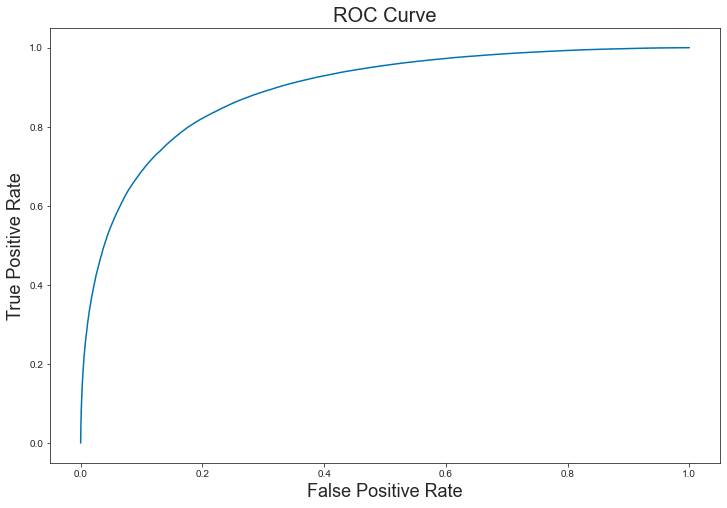

In [86]:
fig, ax = plt.subplots(1, 1, figsize=[12,8])
plt.plot(fpr, tpr)
ax.set_title("ROC Curve", fontsize=20)
ax.set_xlabel("False Positive Rate", fontsize=18)
ax.set_ylabel("True Positive Rate", fontsize=18)
plt.show()

### Analyze feature importance

In [131]:
# We will need to tap into different parts of the Pipeline object to access the different attributes related to each step
cv[0]

FeatureUnion(transformer_list=[('text_pipeline',
                                Pipeline(steps=[('vect',
                                                 CountVectorizer(max_df=0.65,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 tokenizer=<function tokenize at 0x000001C9DB3A2700>)),
                                                ('tfidf',
                                                 TfidfTransformer())]))])

In [89]:
cv[1]

LogisticRegression(solver='saga')

In [94]:
# Finding feature names of the "text_pipeline" FeatureUnion from our Pipeline
cv[0].get_feature_names_out()

array(['text_pipeline__0', 'text_pipeline__0 0', 'text_pipeline__0 00',
       ..., 'text_pipeline__zzzuu adios', 'text_pipeline__zzzy',
       'text_pipeline__zzzy office'], dtype=object)

In [95]:
# Finding the number of features produced by the FeatureUnion
len(cv[0].get_feature_names_out())

3294897

In [96]:
# Finding the intercept from the Logistic Regression classifier
cv[1].intercept_

array([0.42153809])

In [97]:
# Finding the coefficients of the features from the Logistic Regression classifier
cv[1].coef_[0]

array([-1.35424036,  0.30396767,  0.02895388, ..., -0.18388588,
       -0.15624128, -0.15624128])

In [98]:
# Finding the number of features used in the Logistic Regression classifier
cv[1].n_features_in_

3294897

In [99]:
# Finding the minimum and maximum coefficients
min(cv[1].coef_[0]), max(cv[1].coef_[0])

(-20.945463149585503, 12.497028958663186)

In [100]:
# Save the feature names and coefficients
feature_names = cv[0].get_feature_names_out()
feature_coef = cv[1].coef_[0]

In [101]:
# Check they are the same length
len(feature_names), len(feature_coef)

(3294897, 3294897)

In [102]:
# Combining the feature names and coefficients into a dataframe
feature_importance = zip(feature_names, feature_coef)
feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'coefficient'])

In [103]:
feature_importance_df.head(40)

,feature,coefficient
0,text_pipeline__0,-1.354240
1,text_pipeline__0 0,0.303968
2,text_pipeline__0 00,0.028954
3,text_pipeline__0 0001,-0.193227
4,text_pipeline__0 00014,-0.200772
5,text_pipeline__0 005,-0.063102
6,text_pipeline__0 0055,0.042339
7,text_pipeline__0 006,0.091162
8,text_pipeline__0 01,0.147196
9,text_pipeline__0 02,0.154103


In [104]:
# remove the "text_pipeline__" substring to make our dataframe neater
feature_importance_df['feature'] = feature_importance_df.feature.str.replace('text_pipeline__', '')

In [105]:
feature_importance_df

,feature,coefficient
0,0,-1.354240
1,0 0,0.303968
2,0 00,0.028954
3,0 0001,-0.193227
4,0 00014,-0.200772
...,...,...
3294892,zzzs u,0.053984
3294893,zzzuu,-0.183886
3294894,zzzuu adios,-0.183886
3294895,zzzy,-0.156241


In [106]:
# Sort our dataframe
feature_df_sorted = feature_importance_df.sort_values(by='coefficient')

In [107]:
feature_df_sorted

,feature,coefficient
2425263,sad,-20.945463
1821196,miss,-14.668852
2191056,poor,-12.527180
3181435,wish,-11.998884
1830002,missing,-11.885372
...,...,...
2819576,thanks,8.899659
1970023,no problem,10.734823
1994647,not wait,11.529978
1984132,not bad,12.026608


In [108]:
# Find the top 20 features leading to negative and positive classifications
top_neg_features = feature_df_sorted.head(20)
top_pos_features = feature_df_sorted.tail(20)

In [109]:
top_neg_features.sort_values(by='coefficient', ascending=True)

,feature,coefficient
2425263,sad,-20.945463
1821196,miss,-14.668852
2191056,poor,-12.527180
3181435,wish,-11.998884
1830002,missing,-11.885372
1983191,not,-11.809522
2552273,sick,-11.491266
2430295,sadly,-11.229117
1274942,hate,-10.747812
1386830,hurt,-10.288156


We can see words like "sad", "sick", "hate", "bad", "cry" appearing in the most important words leading to a negative classification.

In [110]:
top_pos_features.sort_values(by='coefficient', ascending=False)

,feature,coefficient
481633,cant wait,12.497029
1984132,not bad,12.026608
1994647,not wait,11.529978
1970023,no problem,10.734823
2819576,thanks,8.899659
2816801,thank,8.881687
480290,cannot wait,8.493717
1260155,happy,8.460817
1992148,not sad,8.350655
3183343,wish luck,8.263524


We can see words like "can't wait", "happy", "excited", "love", "good" appearing in the most important words leading to a positive classification.

In [112]:
# Add a column to our dataframe with the absolute value of the coefficient
feature_importance_df['|coefficient|'] = abs(feature_importance_df['coefficient'])

In [113]:
feature_importance_df

,feature,coefficient,|coefficient|
0,0,-1.354240,1.354240
1,0 0,0.303968,0.303968
2,0 00,0.028954,0.028954
3,0 0001,-0.193227,0.193227
4,0 00014,-0.200772,0.200772
...,...,...,...
3294892,zzzs u,0.053984,0.053984
3294893,zzzuu,-0.183886,0.183886
3294894,zzzuu adios,-0.183886,0.183886
3294895,zzzy,-0.156241,0.156241


In [114]:
# Find the top 20 overall most impactful features regardless of what class they relate to
top_20_features = feature_importance_df.sort_values(by='|coefficient|', ascending=False).round(6).head(20)[['feature', 'coefficient']]

In [115]:
top_20_features

,feature,coefficient
2425263,sad,-20.945463
1821196,miss,-14.668852
2191056,poor,-12.527180
481633,cant wait,12.497029
1984132,not bad,12.026608
3181435,wish,-11.998884
1830002,missing,-11.885372
1983191,not,-11.809522
1994647,not wait,11.529978
2552273,sick,-11.491266


## Plots

### Plot the most important features

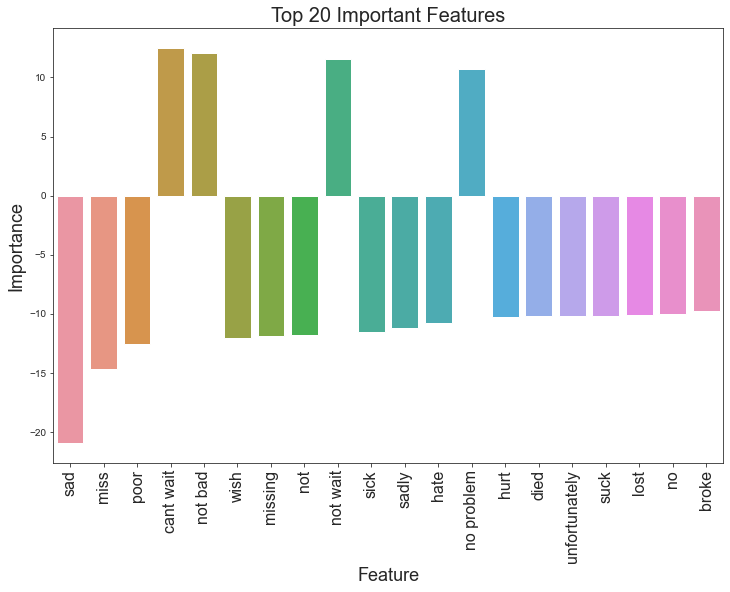

In [116]:
fig, ax = plt.subplots(1, 1, figsize=[12,8])
sns.barplot(x="feature", y="coefficient", data=top_20_features)
ax.set_title("Top 20 Important Features", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
plt.show()

### Plot the top 20 positive features

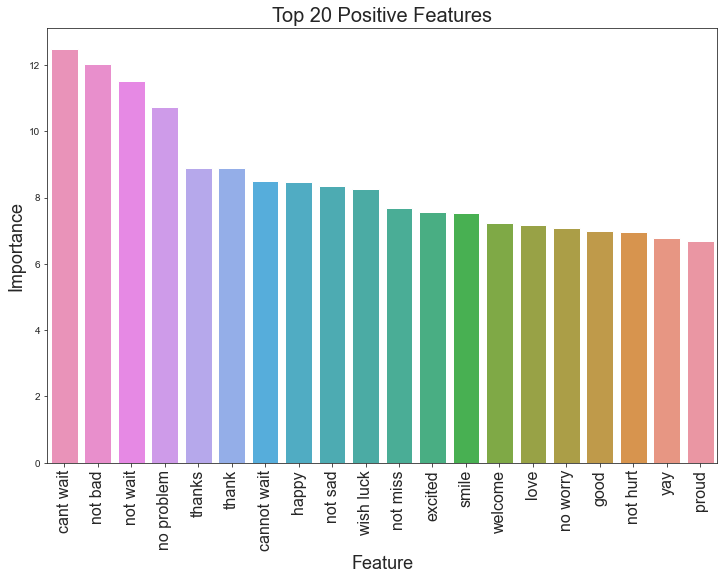

In [117]:
fig, ax = plt.subplots(1, 1, figsize=[12,8])
sns.barplot(x='feature', y='coefficient', data=top_pos_features).invert_xaxis()
ax.set_title("Top 20 Positive Features", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
plt.show()

### Plot the top 20 negative features

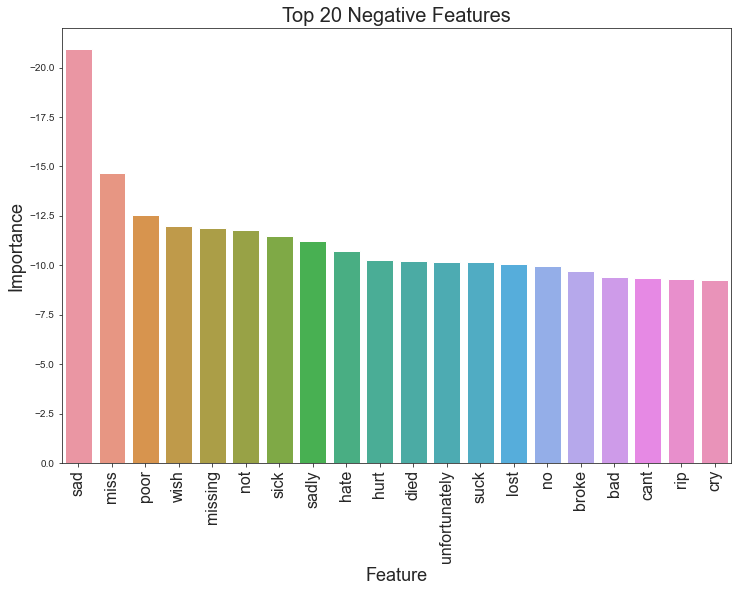

In [118]:
fig, ax = plt.subplots(1, 1, figsize=[12,8])
sns.barplot(x='feature', y='coefficient', data=top_neg_features).invert_yaxis()
ax.set_title("Top 20 Negative Features", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
plt.show()

## Code to load the model from the pickle file to make predictions on new data in the future

In [132]:
# Load the pickle file
model = pickle.load(open('final_model.pkl', 'rb'))